Poker variance model created for the purposes of bankroll/risk management. I've added a few features to the primedope models.

In [1]:
import numpy as np
from scipy.stats import norm
import random
import matplotlib.pyplot as plt


Model allowing multiple stakes to be played, which the primedope model lacks. The inputs for stakes are meant to be in dollars and the individual entries represent the dollar amounts of the big blind. So stakes = np.array([1,5,10]) for instance represents the collection 0.5/1 blinds, 2.5/5 blinds and 5/10 blinds. The individual entries of n_hands and winrates correspond to those quantities for the corresponding stake.
The results from individual hands are assumed to follow a Normal distribution with given win rate and sd. We get resonable convergence to a Normal distribution after a few hundred hands from the Central Limit Theorem. Justification found towards the end of the notebook.
Results in this model follow from the properties of the sums of IID distributions.

70% confidence interval on winnings:[-5364.33 15364.33]
95% confidence interval on winnings:[-14599.64  24599.64]
99% confidence interval on winnings:[-20758.29  30758.29]


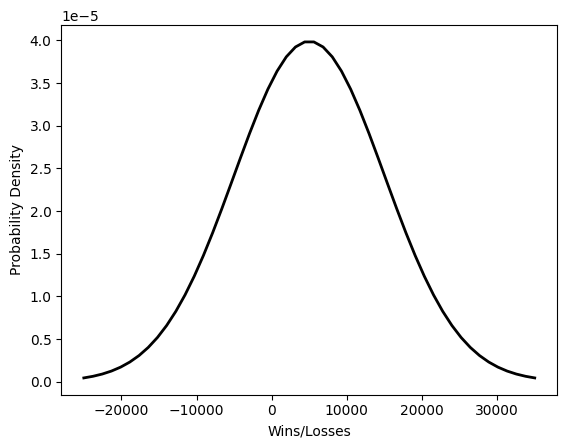

In [5]:
stakes = np.array([2,5,10])
n_hands = np.array([0,0,10000])
win_rates_100 = np.array([0,0,5])
std_dev_100 = np.array([100,100,100])

std_dev = std_dev_100*0.1              #the std per hand is .1 of the std per 100 hands
win_rates = win_rates_100*0.01         #the win rate per hand is .01 of the win rate per 100 hands

#computing the EVs per stake
stake_mean = stakes*n_hands*win_rates
total_mean = sum(stake_mean)            #total EV

stake_std = (n_hands**.5)*stakes*std_dev
total_std = (np.sum(stake_std*stake_std))**.5

mu, sigma = total_mean, total_std

conf_70 = [-(norm.ppf(0.85))*sigma + mu, (norm.ppf(0.85))*sigma + mu]
conf_95 = [-(norm.ppf(0.975))*sigma + mu, (norm.ppf(0.975))*sigma + mu]
conf_99 = [-(norm.ppf(0.995))*sigma + mu, (norm.ppf(0.995))*sigma + mu]

print("70% confidence interval on winnings:" + str(np.round(conf_70,2)))
print("95% confidence interval on winnings:" + str(np.round(conf_95,2)))
print("99% confidence interval on winnings:" + str(np.round(conf_99,2)))

plt.xlabel('Wins/Losses')
plt.ylabel('Probability Density')

x = np.linspace(mu - 3*sigma, mu + 3*sigma)
y = norm.pdf(x, mu, sigma)            #Limit normal distribution

plt.plot(x, y, 'k', linewidth=2)

plt.show()

Monte Carlo simulation based models

This next model allows for setting threshold for moving up and down stakes as well as a bad beat jackpot, which has a significant effect on the distribution of winnings. The resulting distribution should be something in between a Normal and Log Normal distribtuion.


Justification for the Normal distribution assumption

The empirical wins and losses and their associated are approximated from a sample of 600k I've played in a PokerTracker4 database with the average win/loss normalized to 0. The empirical_std of 10 Big Blinds per hand corresponds to 100 per 100 hands, which is approximately the avereage in 6-handed nlh games. After a few hundred hands, the limit Normal distribution with mu = empirical_avg and std = empirical_std*sqrt(n_hands) closely approximates the true distribution of winnings.

10.049378090210357


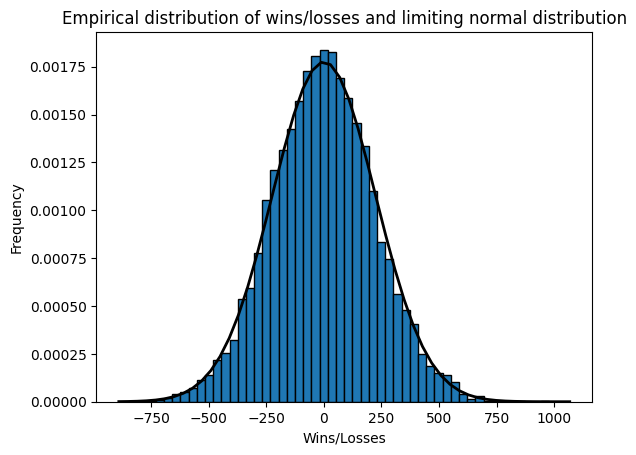

In [2]:
n_hands = 500 #number of hands to be simulated for bootstrap batch
n_sims = 10000 #number of bootstrap batches
win_loss = np.array([0, 1, -1, 3, -3, 10, -10, 30, -30, 100, -100]) #win/loss sizes in BB
win_loss_probs = 0.01*np.array([43.7, 16.5, 16.5, 7, 7, 3, 3, 1.3, 1.3, .35, .35]) #win/loss frequencies

#function to compute the average and standard deviation of the win/loss
def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    standard_dev = variance**.5
    return (average, standard_dev)

empirical_avg, empirical_std = weighted_avg_and_std(win_loss, win_loss_probs)
print(empirical_std)
 
def bootstrap(n_sims, n_hands):
    sims = []
    for i in range(n_sims):
        sim = np.random.choice(win_loss, size=n_hands, p=win_loss_probs)
        sims.append(sum(sim))
    return sims

#running n_sims iterations of the bootstrap, each simulating n_hands from the empirical win/loss distribution
sims = bootstrap(n_sims, n_hands)

#plotting a histogram of the simulated wins/losses in BBs after n_hands
plt.hist(sims, bins=50, edgecolor='black', density = True)

# Adding labels and title
plt.xlabel('Wins/Losses')
plt.ylabel('Frequency')
plt.title('Empirical distribution of wins/losses and limiting normal distribution')

#Setting the mean and std of the limit normal distribution. From the Central Limit Theorem, the std scales by the squareroot of n_hands.
mu, std = empirical_avg, empirical_std*(n_hands)**.5

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax)

#Limit normal distribution
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)

plt.show()